<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-packages-and-modules" data-toc-modified-id="Import-packages-and-modules-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import packages and modules</a></span></li><li><span><a href="#Generate-example-dataset" data-toc-modified-id="Generate-example-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate example dataset</a></span></li><li><span><a href="#Plot-data,-set-expectations" data-toc-modified-id="Plot-data,-set-expectations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot data, set expectations</a></span></li><li><span><a href="#Models" data-toc-modified-id="Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><span><a href="#eta-squared-function" data-toc-modified-id="eta-squared-function-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>eta-squared function</a></span></li><li><span><a href="#Dummy-codes" data-toc-modified-id="Dummy-codes-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Dummy codes</a></span><ul class="toc-item"><li><span><a href="#Model-matrix-if-you-multiply-dummy-coded-factors" data-toc-modified-id="Model-matrix-if-you-multiply-dummy-coded-factors-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Model matrix if you multiply dummy-coded factors</a></span></li><li><span><a href="#This-coding-scheme-gives-you-two-main-effects-and-an-interaction" data-toc-modified-id="This-coding-scheme-gives-you-two-main-effects-and-an-interaction-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>This coding scheme gives you two main effects and an interaction</a></span></li><li><span><a href="#Fit-model" data-toc-modified-id="Fit-model-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Fit model</a></span></li></ul></li><li><span><a href="#Coefficient-estimates-+-other-model-info" data-toc-modified-id="Coefficient-estimates-+-other-model-info-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Coefficient estimates + other model info</a></span><ul class="toc-item"><li><span><a href="#ANOVA-source-table" data-toc-modified-id="ANOVA-source-table-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>ANOVA source table</a></span></li></ul></li><li><span><a href="#Custom-codes" data-toc-modified-id="Custom-codes-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Custom codes</a></span><ul class="toc-item"><li><span><a href="#Fit-model" data-toc-modified-id="Fit-model-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Fit model</a></span></li></ul></li><li><span><a href="#Coefficient-estimates-+-other-model-info" data-toc-modified-id="Coefficient-estimates-+-other-model-info-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Coefficient estimates + other model info</a></span><ul class="toc-item"><li><span><a href="#ANOVA-source-table" data-toc-modified-id="ANOVA-source-table-4.5.1"><span class="toc-item-num">4.5.1&nbsp;&nbsp;</span>ANOVA source table</a></span></li></ul></li><li><span><a href="#Custom-codes-using-factor1-and-factor2-variables" data-toc-modified-id="Custom-codes-using-factor1-and-factor2-variables-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Custom codes using factor1 and factor2 variables</a></span><ul class="toc-item"><li><span><a href="#Fit-model" data-toc-modified-id="Fit-model-4.6.1"><span class="toc-item-num">4.6.1&nbsp;&nbsp;</span>Fit model</a></span></li></ul></li><li><span><a href="#Coefficient-estimates-+-other-model-info" data-toc-modified-id="Coefficient-estimates-+-other-model-info-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Coefficient estimates + other model info</a></span><ul class="toc-item"><li><span><a href="#ANOVA-source-table" data-toc-modified-id="ANOVA-source-table-4.7.1"><span class="toc-item-num">4.7.1&nbsp;&nbsp;</span>ANOVA source table</a></span></li></ul></li><li><span><a href="#Effect-code-main-effects-and-interactions-as-float-predictors" data-toc-modified-id="Effect-code-main-effects-and-interactions-as-float-predictors-4.8"><span class="toc-item-num">4.8&nbsp;&nbsp;</span>Effect code main effects and interactions as float predictors</a></span></li><li><span><a href="#Fit-bayesian-GLM-with-student-t-priors" data-toc-modified-id="Fit-bayesian-GLM-with-student-t-priors-4.9"><span class="toc-item-num">4.9&nbsp;&nbsp;</span>Fit bayesian GLM with student t priors</a></span><ul class="toc-item"><li><span><a href="#Trace-plots" data-toc-modified-id="Trace-plots-4.9.1"><span class="toc-item-num">4.9.1&nbsp;&nbsp;</span>Trace plots</a></span></li><li><span><a href="#Summary-of-results" data-toc-modified-id="Summary-of-results-4.9.2"><span class="toc-item-num">4.9.2&nbsp;&nbsp;</span>Summary of results</a></span></li><li><span><a href="#Linear-regression-results-for-comparison" data-toc-modified-id="Linear-regression-results-for-comparison-4.9.3"><span class="toc-item-num">4.9.3&nbsp;&nbsp;</span>Linear regression results for comparison</a></span></li><li><span><a href="#Compare-sd-in-trace-plots-to-mean-square-residual-in-ANOVA-source-table" data-toc-modified-id="Compare-sd-in-trace-plots-to-mean-square-residual-in-ANOVA-source-table-4.9.4"><span class="toc-item-num">4.9.4&nbsp;&nbsp;</span>Compare sd in trace plots to mean square residual in ANOVA source table</a></span></li></ul></li></ul></li></ul></div>

# Import packages and modules

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pymc3
import patsy

# set seaborn style
sns.set(palette = "colorblind", font_scale = 2)

# Generate example dataset

In [122]:
# id
subject_id = list(range(120))

# group
group = np.repeat([1, 2, 3, 4], [30, 30, 30, 30])

# factors
factor1 = [{1: "A", 2: "A", 3: "B", 4: "B"}[x] for x in group]
factor2 = [{1: "A", 2: "B", 3: "A", 4: "B"}[x] for x in group]

# y
y = np.concatenate([np.random.normal(m, s, n) for m, s, n in zip([3, 4, 4, 3], [1, 1, 1, 1], [30, 30, 30, 30])])

# store in data frame
tutorial_data = pd.DataFrame({"subject_id": subject_id, "group": group, "factor1": factor1, "factor2": factor2, "y": y})

# see it
tutorial_data

,subject_id,group,factor1,factor2,y
0,0,1,A,A,4.211297
1,1,1,A,A,2.879661
2,2,1,A,A,2.661569
3,3,1,A,A,3.493066
4,4,1,A,A,2.394434
...,...,...,...,...,...
115,115,4,B,B,3.313894
116,116,4,B,B,3.754366
117,117,4,B,B,4.175933
118,118,4,B,B,2.155325


# Plot data, set expectations

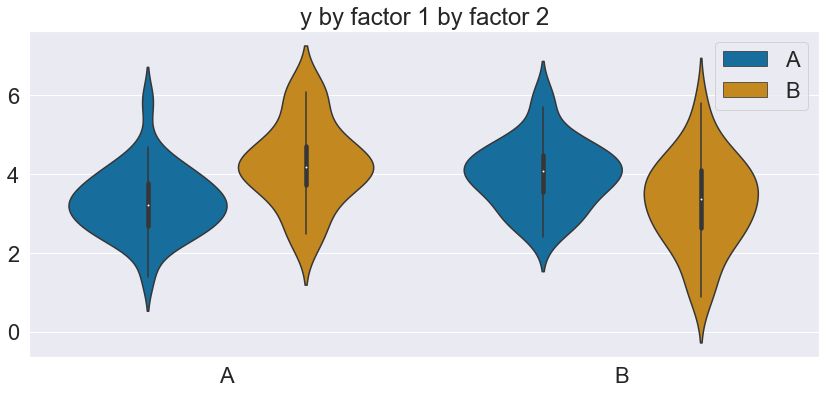

In [123]:
# figure
plt.figure(figsize = (12, 6))

# violin plot
sns.violinplot(x = "factor1", y = "y", hue = "factor2", data = tutorial_data)

# titles
plt.title("y by factor 1 by factor 2")
plt.xlabel(None)
plt.ylabel(None)

# legend
plt.legend(loc = "best")

# fix plot
plt.tight_layout()

# Models

## eta-squared function
$\eta^2 = \frac{SS_{Effect}}{SS_{Total}}$

In [124]:
def eta_squared(anova_lm_df):
    # total sum of squares
    sst = anova_lm_df["sum_sq"].sum()
    
    # add eta_squared to df
    anova_lm_df["eta_squared"] = [ss / sst for ss in anova_lm_df["sum_sq"]]
    
    # return df
    return anova_lm_df

## Dummy codes

### Model matrix if you multiply dummy-coded factors

In [125]:
patsy.dmatrix("C(factor1, [[0], [1]]) * C(factor2, [[0], [1]])", data = pd.DataFrame({"factor1": [1, 1, 2, 2], "factor2": [1, 2, 1, 2]}))[:, :]

array([[1., 0., 0., 0.],
       [1., 0., 1., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 1.]])

Ruins interpretation of main effects:  

Group 1: $y_i = \beta_0 + \beta_1(0) + \beta_2(0) + \beta_3(0)$  
Group 2: $y_i = \beta_0 + \beta_1(1) + \beta_2(0) + \beta_3(0)$   
Group 3: $y_i = \beta_0 + \beta_1(0) + \beta_2(1) + \beta_3(0)$   
Group 4: $y_i = \beta_0 + \beta_1(1) + \beta_2(1) + \beta_3(1)$  

$\beta_0 = \mu_{Group 1}$  
$\beta_1 = \mu_{Group 2} - \beta_0 = \mu_{Group 2} - \mu_{Group 1}$  
$\beta_2 = \mu_{Group 3} - \beta_0 = \mu_{Group 3} - \mu_{Group 1}$  
$\beta_3 = \mu_{Group 4} - \beta_0 - \beta_1 - \beta_2$  
$\beta_3 = \mu_{Group 4} - \mu_{Group 1} - (\mu_{Group 2} - \mu_{Group 1}) - (\mu_{Group 3} - \mu_{Group 1})$  
$\beta_3 = \mu_{Group 1} - \mu_{Group 2} - \mu_{Group 3} + \mu_{Group 4}$

### This coding scheme gives you two main effects and an interaction

In [126]:
patsy.dmatrix("C(group, [[0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 1]])", data = pd.DataFrame({"group": [1, 2, 3, 4]}))[:, :]

array([[1., 0., 0., 1.],
       [1., 0., 1., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 1.]])

### Fit model

In [127]:
# index = 0 used as reference group
ols_fit1 = smf.ols("y ~ C(group, [[0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 1]])", data = tutorial_data).fit()

## Coefficient estimates + other model info

In [128]:
ols_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     7.536
Date:                Sun, 26 Jul 2020   Prob (F-statistic):           0.000119
Time:                        12:29:46   Log-Likelihood:                -165.73
No. Observations:                 120   AIC:                             339.5
Df Residuals:                     116   BIC:                             350.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           4.1329      0.179     23.115      0.000       3.779       4.487
C(group, [[0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 1]])[custom0]    -0.1389      0.179     -0.777      0.439      -0.493       0.215
C(group, [[0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 1]])[custom1]     0.1177      0.179      0.658      0.512      -0.236       0.472
C(group, [[0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 1]])[custom2]    -0.8304      0.179     -4.644      0.000      -1.185      -0.476
==============================================================================
Omnibus:                        0.733   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.693   Jarque-Bera (JB):                0.406
Skew:                           0.120   Prob(JB):                        0.816
Kurtosis:                       3.154   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ANOVA source table

In [129]:
eta_squared(
    sm.stats.anova_lm(ols_fit1, type = 3)
)

,df,sum_sq,mean_sq,F,PR(>F),eta_squared
"C(group, [[0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 1]])",3.0,21.681769,7.227256,7.535827,0.000119,0.163104
Residual,116.0,111.250134,0.959053,NaN,NaN,0.836896


## Custom codes

In [130]:
np.array([[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])

array([[-0.5, -0.5,  0.5],
       [-0.5,  0.5, -0.5],
       [ 0.5, -0.5, -0.5],
       [ 0.5,  0.5,  0.5]])

### Fit model

In [131]:
# index = 0 used as reference group
ols_fit2 = smf.ols("y ~ C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])", data = tutorial_data).fit()

## Coefficient estimates + other model info

In [132]:
ols_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     7.536
Date:                Sun, 26 Jul 2020   Prob (F-statistic):           0.000119
Time:                        12:29:46   Log-Likelihood:                -165.73
No. Observations:                 120   AIC:                             339.5
Df Residuals:                     116   BIC:                             350.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================================================
                                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                         3.7071      0.089     41.467      0.000       3.530       3.884
C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])[custom0]    -0.1389      0.179     -0.777      0.439      -0.493       0.215
C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])[custom1]     0.1177      0.179      0.658      0.512      -0.236       0.472
C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])[custom2]    -0.8304      0.179     -4.644      0.000      -1.185      -0.476
==============================================================================
Omnibus:                        0.733   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.693   Jarque-Bera (JB):                0.406
Skew:                           0.120   Prob(JB):                        0.816
Kurtosis:                       3.154   Cond. No.                         2.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ANOVA source table

In [133]:
eta_squared(
    sm.stats.anova_lm(ols_fit2, type = 3)
)

,df,sum_sq,mean_sq,F,PR(>F),eta_squared
"C(group, [[-0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, -0.5, -0.5], [0.5, 0.5, 0.5]])",3.0,21.681769,7.227256,7.535827,0.000119,0.163104
Residual,116.0,111.250134,0.959053,NaN,NaN,0.836896


## Custom codes using factor1 and factor2 variables

In [134]:
np.array([[-0.5], [0.5]])

array([[-0.5],
       [ 0.5]])

### Fit model

In [135]:
# index = 0 used as reference group
ols_fit3 = smf.ols("y ~ C(factor1, [[-0.5], [0.5]]) * C(factor2, [[-0.5], [0.5]])", data = tutorial_data).fit()

## Coefficient estimates + other model info

In [136]:
ols_fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     7.536
Date:                Sun, 26 Jul 2020   Prob (F-statistic):           0.000119
Time:                        12:29:46   Log-Likelihood:                -165.73
No. Observations:                 120   AIC:                             339.5
Df Residuals:                     116   BIC:                             350.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                     3.7071      0.089     41.467      0.000       3.530       3.884
C(factor1, [[-0.5], [0.5]])[custom0]                                         -0.1389      0.179     -0.777      0.439      -0.493       0.215
C(factor2, [[-0.5], [0.5]])[custom0]                                          0.1177      0.179      0.658      0.512      -0.236       0.472
C(factor1, [[-0.5], [0.5]])[custom0]:C(factor2, [[-0.5], [0.5]])[custom0]    -1.6608      0.358     -4.644      0.000      -2.369      -0.953
==============================================================================
Omnibus:                        0.733   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.693   Jarque-Bera (JB):                0.406
Skew:                           0.120   Prob(JB):                        0.816
Kurtosis:                       3.154   Cond. No.                         4.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ANOVA source table

In [137]:
eta_squared(
    sm.stats.anova_lm(ols_fit3, type = 3)
)

,df,sum_sq,mean_sq,F,PR(>F),eta_squared
"C(factor1, [[-0.5], [0.5]])",1.0,0.579054,0.579054,0.603777,0.438722,0.004356
"C(factor2, [[-0.5], [0.5]])",1.0,0.415336,0.415336,0.433069,0.511791,0.003124
"C(factor1, [[-0.5], [0.5]]):C(factor2, [[-0.5], [0.5]])",1.0,20.687380,20.687380,21.570635,0.000009,0.155624
Residual,116.0,111.250134,0.959053,NaN,NaN,0.836896


## Effect code main effects and interactions as float predictors

In [138]:
effect1 = [{1: -0.5, 2: -0.5, 3: 0.5, 4: 0.5}[x] for x in group]
effect2 = [{1: -0.5, 2: 0.5, 3: -0.5, 4: 0.5}[x] for x in group]
interaction = [{1: 0.5, 2: -0.5, 3: -0.5, 4: 0.5}[x] for x in group]

## Fit bayesian GLM with student t priors
Prior choices loosely based on [Prior Choice Recommendations from Andrew Gelman](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)

In [ ]:
with pymc3.Model() as tutorial_model:
    # define priors, mean = 0, sd = 1, df = 10
    priors = {"Intercept": pymc3.StudentT.dist(mu = 0, sigma = 1, nu = 10),
             "effect1": pymc3.StudentT.dist(mu = 0, sigma = 1, nu = 10),
             "effect2": pymc3.StudentT.dist(mu = 0, sigma = 1, nu = 10),
             "interaction": pymc3.StudentT.dist(mu = 0, sigma = 1, nu = 10)}
    
    # model formula
    pymc3.GLM.from_formula("y ~ effect1 + effect2 + interaction", data = tutorial_data, priors = priors)
    
    # sample
    tutorial_trace = pymc3.sample(draws = 2000, cores = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, interaction, effect2, effect1, Intercept]


### Trace plots

In [ ]:
# figure
plt.figure(figsize = (14, 7))

# trace plot
pymc3.traceplot(tutorial_trace)

# fix plot
plt.tight_layout();

### Summary of results

In [ ]:
pymc3.summary(tutorial_trace, hdi_prob = 0.95)

### Linear regression results for comparison

In [ ]:
ols_fit2.summary()

### Compare sd in trace plots to mean square residual in ANOVA source table

In [ ]:
sm.stats.anova_lm(ols_fit2, type = 3)